In [272]:
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.circuit import ParameterVector
from qiskit.visualization import plot_histogram
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.decomposition import NMF

In [273]:
# I am using the SVD descomposition:
# https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
# And put the diagonal matrix into the quantum circuit.
# The image is decreased in size by 2. (28x28) --> (14x14)
# The porpuse is to have just 14 values to put into the quantum circuit.

X = np.array([[1,2,3],[4,5,6],[7,8,9]])
W = np.linalg.svd(X)
np.dot(W[0] * W[1], W[2])
np.diag(W[1])

array([[1.68481034e+01, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.06836951e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.33475287e-16]])

# Data Loading

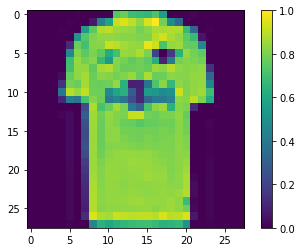

In [274]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
images = (images/0.00392156862745098)
select_image = 2
plt.imshow(images[select_image])
plt.colorbar()
plt.show()

# Part 1 - Encoding

Image before:
The shape of the images is: (2000, 28, 28)


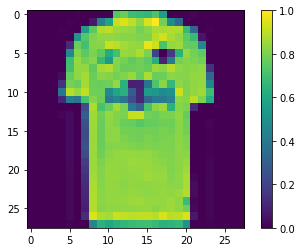

In [275]:
size = np.array([14,14])
area = 7*2
Shots = 10000
select_image = 2

images2 = images
images2 = images2.reshape(images2.shape[0], *(28,28,1))

images2 = tf.image.resize(images2, (size[0],size[1])).numpy()

print("Image before:")
plt.imshow(images[select_image])
print("The shape of the images is: {}".format(images.shape))
plt.colorbar()
plt.show()

Image then:
The shape of the images is: (2000, 14, 14, 1)


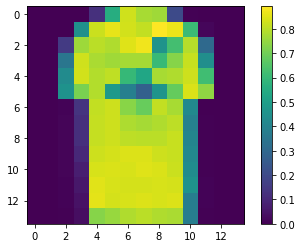

In [276]:
print("Image then:")
print("The shape of the images is: {}".format(images2.shape))
Real_values = images2[select_image]
plt.imshow(images2[select_image])
plt.colorbar()
plt.show()

In [277]:
T = np.asarray(images2[select_image])
T = T.reshape(14,14)
W = np.linalg.svd(T)
# Convert: np.dot(W[0]*W[1], W[2])

In [278]:
#images3 = images3.reshape(images3.shape[0], *(1,area,1))

# Encoding Function

In [279]:
def Encode(select_image, area):
    
    T = np.asarray(images2[select_image])
    T = T.reshape(14,14)
    W = np.linalg.svd(T)

    p = ParameterVector('p', area) 
    qc = QuantumCircuit(area)
    for i in range(area):
        qc.rx(p[i],i)
    # bind parameters
    for i in range(area):
        qc = qc.bind_parameters({p[i]: np.pi/2*(W[1][i]/(W[1].max()))})
    
    qc.measure_all()
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=Shots)
    res = job.result().get_counts(qc)
    return res, W

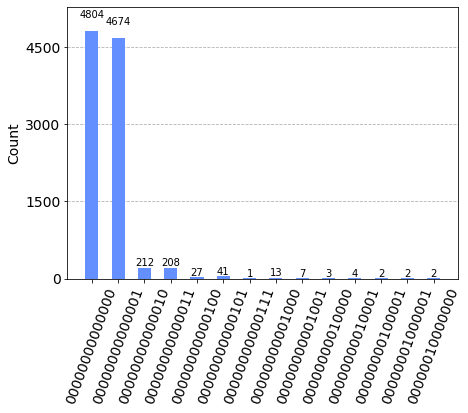

In [280]:
res, W = Encode(select_image, area)
plot_histogram(res)

# Part 2 - Decoding

In [281]:
def Decode(hist, w, area):
    keys = np.array(list(hist.keys()))
    for k in range(len(keys)):
        keys[k] = int(keys[k],2)
    keys = np.array(keys, dtype='int64')
    values = np.array(list(hist.values()))
    values = values/Shots
    new_dict = {keys[i]: values[i] for i in range(len(keys))}
    parameter_list = []
    
    if (1 in keys):
        parameter_list.append(2*np.arctan(np.sqrt(new_dict[1]/new_dict[0])))  
    else:
        parameter_list.append(0)
    
    value = 1
    for j in range(area-1):
        value *= 2
        if (value in keys):
            parameter_list.append(2*np.arctan(np.sqrt(new_dict[value]/new_dict[0])))
        else:
            parameter_list.append(0)
    #    else:
    #        parameter_list.append(2*np.arctan(np.sqrt(new_dict[value]/new_dict[0])))
    
    parameter_list = np.array(parameter_list, dtype='float32')
    parameter_list = (parameter_list*w[1].max())/(np.pi/2)
    #parameter_list = parameter_list.reshape(size[0],size[1])
    
    return parameter_list

In [282]:
def Testing(image, area):
    res, W = Encode(image, area)
    dec = Decode(res, W, area)
    
    real_image = images2[image]
    gen_image = np.dot(W[0] * dec, W[2])
    
    return real_image, gen_image

real, gen = Testing(1, area)

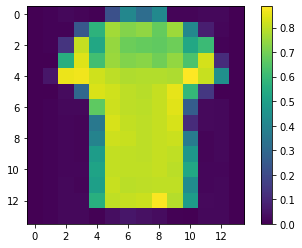

In [283]:
plt.imshow(real)
plt.colorbar()
plt.show()

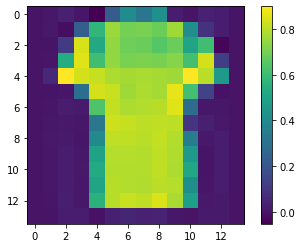

In [284]:
plt.imshow(gen)
plt.colorbar()
plt.show()

In [285]:
def Testing_grad(image, area):
    res, W = Encode(image, area)
    dec = Decode(res, W, area)
    
    real_image = images2[image]
    gen_image = np.dot(W[0] * dec, W[2])
    
    return mean_squared_error(real_image.reshape(1,-1)[0], gen_image.reshape(1,-1)[0])

In [286]:
meas = Testing_grad(1,area)
1-meas

0.9998789019809919

In [287]:
# Fidelity:

mse = 0
count = 0
for i in range(len(images2)):
    count += 1
    #print(count) # to measure the progress.
    res, w = Encode(i, area)
    dec = Decode(res, w, area)
    mse += Testing_grad(i,area)

print(1-mse/len(images2))

0.9998288535776948


In [288]:
print(1-mse/len(images2))

0.9998288535776948
